用不同长度的轨迹训练自编码器

长度：2s

方法：单向重构

---


In [1]:
# 直接训练
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import os

from torch.utils.tensorboard import SummaryWriter

from model.PIAE_models import T8PIAE1, Vehicle_Model_Methods
import numpy as np

# 检查是否有可用的GPU
if torch.cuda.is_available():
    print('显卡参与训练')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 训练开始前启用 PyTorch 的异常检测
torch.autograd.set_detect_anomaly(True)

显卡参与训练


In [2]:
# 加载数据
# 1. 加载预处理后的数据
##

def load_preprocessed_data(input_file):
    with open(input_file, 'rb') as f:
        data = pickle.load(f)
    return data


input_file = '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/data/data2s'  # 替换为你保存的.pkl文件路径

tarin_data = load_preprocessed_data(os.path.join(input_file,'train_data.kpl'))
val_data = load_preprocessed_data(os.path.join(input_file,'val_data.kpl'))
dataset = TensorDataset(tarin_data[0],tarin_data[1],tarin_data[2],tarin_data[3])

dataloader = DataLoader(dataset, batch_size=600, shuffle=True)

val_feat = val_data[0].to(device)
val_edagepoint = val_data[1].to(device)
val_endstate = val_data[2].to(device)
val_label = val_data[3].to(device)

In [3]:

class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()

    def forward(self,outputs, targets, actions):

        mse_loss = nn.MSELoss()(outputs, targets)

        # 平滑loss
        ax = actions[:, :, 0]
        delta = actions[:, :, 1]

        loss_ax = torch.mean(torch.abs(torch.diff(ax,dim=1)))
        loss_delta = torch.mean(torch.abs(torch.diff(delta,dim=1)))*10
    
        return mse_loss + 1e-3*(loss_ax+loss_delta)

In [4]:

# 3. 定义模型、损失函数和优化器
#模型
model = T8PIAE1(torch.tensor(10),torch.tensor(0.25),t_len=20)

# 损失函数
criterion = nn.MSELoss()
criterion_train = CustomLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

model.to(device)


T8PIAE1(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=38, out_features=800, bias=True)
    (2): ReLU()
    (3): Linear(in_features=800, out_features=400, bias=True)
    (4): ReLU()
  )
  (encoder_ax): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=18, bias=True)
    (3): Tanh()
  )
  (encoder_delta): Sequential(
    (0): Linear(in_features=200, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=18, bias=True)
    (3): Tanh()
  )
)

In [5]:
%clear

# 创建一个SummaryWriter对象，指定日志保存的路径
writer = SummaryWriter('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/logs/log3')


# 4. 训练模型Autoencoder
epochs = 600

best_loss = float('inf')

for epoch in range(epochs):
    
    model.train()  # 确保模型处于训练模式
    for batch_idx, (feat,edagepoint,endstate,label) in enumerate(dataloader):  
        
        label = label.to(device)  # 将输入数据移动到同一设备
        feat = feat.to(device)
        edagepoint = edagepoint.to(device)
        endstate = endstate.to(device)

        optimizer.zero_grad()
        outputs,actions = model(feat,edagepoint,endstate)

        loss = criterion_train(outputs, label,actions)
        loss.backward()
        optimizer.step()


    model.eval()
    with torch.no_grad():
        val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
        val_loss = criterion(val_output,val_label)
    
    # torch.save(model.state_dict(), f'/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test6_piae_good/model/Task4_trained_model/model_{epoch:03}.pth')
    if val_loss.item() < best_loss :
        # 保存模型
        torch.save(model.state_dict(), '/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task3_model_best.pth')
        best_loss = val_loss.item()


    print(f'\rEpoch {epoch+1}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()} ')
    # print()
    # 使用SummaryWriter记录数据
    writer.add_scalar('Loss/train', loss, epoch)
    writer.add_scalar('Loss/val', val_loss, epoch)


# 关闭SummaryWriter
writer.close()
   


Epoch 1, Train Loss: 0.012125707231462002, Val Loss: 0.012843993492424488 


Epoch 2, Train Loss: 0.018067684024572372, Val Loss: 0.028596501797437668 


Epoch 3, Train Loss: 0.010719150304794312, Val Loss: 0.014910971745848656 


Epoch 4, Train Loss: 0.006683748215436935, Val Loss: 0.007138293236494064 


Epoch 5, Train Loss: 0.003881412325426936, Val Loss: 0.006966788321733475 


Epoch 6, Train Loss: 0.0059293173253536224, Val Loss: 0.006754279136657715 


Epoch 7, Train Loss: 0.006237057037651539, Val Loss: 0.004977685399353504 


Epoch 8, Train Loss: 0.003648695768788457, Val Loss: 0.006294177379459143 


Epoch 9, Train Loss: 0.002795664593577385, Val Loss: 0.004099858924746513 


Epoch 10, Train Loss: 0.00184944411739707, Val Loss: 0.004274077247828245 


Epoch 11, Train Loss: 0.0036111108493059874, Val Loss: 0.006430325098335743 


Epoch 12, Train Loss: 0.006778842303901911, Val Loss: 0.004156626760959625 


Epoch 13, Train Loss: 0.007807845715433359, Val Loss: 0.0054442849941551685 


Epoch 14, Train Loss: 0.007617245893925428, Val Loss: 0.004381745122373104 


Epoch 15, Train Loss: 0.0015687381383031607, Val Loss: 0.0037172148004174232 


Epoch 16, Train Loss: 0.002643813379108906, Val Loss: 0.004579790402203798 


Epoch 17, Train Loss: 0.010849019512534142, Val Loss: 0.003168786410242319 


Epoch 18, Train Loss: 0.0021965238265693188, Val Loss: 0.003396331099793315 


Epoch 19, Train Loss: 0.0026946263387799263, Val Loss: 0.0037063825875520706 


Epoch 20, Train Loss: 0.004515661392360926, Val Loss: 0.007382057141512632 


Epoch 21, Train Loss: 0.011763916350901127, Val Loss: 0.013624564744532108 


Epoch 22, Train Loss: 0.003370880149304867, Val Loss: 0.00423829210922122 


Epoch 23, Train Loss: 0.0014316873857751489, Val Loss: 0.0037737349048256874 


Epoch 24, Train Loss: 0.0015210906276479363, Val Loss: 0.0031891458202153444 


Epoch 25, Train Loss: 0.0034736066590994596, Val Loss: 0.0035198938567191362 


Epoch 26, Train Loss: 0.0016058700857684016, Val Loss: 0.0033484995365142822 


Epoch 27, Train Loss: 0.008764405734837055, Val Loss: 0.008105600252747536 


Epoch 28, Train Loss: 0.0013493701117113233, Val Loss: 0.003292877459898591 


Epoch 29, Train Loss: 0.010140929371118546, Val Loss: 0.007164923008531332 


Epoch 30, Train Loss: 0.0019185524433851242, Val Loss: 0.003410210832953453 


Epoch 31, Train Loss: 0.011739097535610199, Val Loss: 0.008047498762607574 


Epoch 32, Train Loss: 0.004558225627988577, Val Loss: 0.0032441795337945223 


Epoch 33, Train Loss: 0.0021724055986851454, Val Loss: 0.004519148264080286 


Epoch 34, Train Loss: 0.003046286292374134, Val Loss: 0.004329116549342871 


Epoch 35, Train Loss: 0.0011904183775186539, Val Loss: 0.0030991246458142996 


Epoch 36, Train Loss: 0.0024554086849093437, Val Loss: 0.003495480865240097 


Epoch 37, Train Loss: 0.01030274759978056, Val Loss: 0.003304498502984643 


Epoch 38, Train Loss: 0.0012945248745381832, Val Loss: 0.0031643786933273077 


Epoch 39, Train Loss: 0.0032553039491176605, Val Loss: 0.0035009996499866247 


Epoch 40, Train Loss: 0.00900245737284422, Val Loss: 0.0037762257270514965 


Epoch 41, Train Loss: 0.0015661795623600483, Val Loss: 0.0031380022410303354 


Epoch 42, Train Loss: 0.0016334386309608817, Val Loss: 0.0031501143239438534 


Epoch 43, Train Loss: 0.0068699149414896965, Val Loss: 0.004849253688007593 


Epoch 44, Train Loss: 0.0010189086897298694, Val Loss: 0.003245729021728039 


Epoch 45, Train Loss: 0.0015670901630073786, Val Loss: 0.003551758360117674 


Epoch 46, Train Loss: 0.0019070332637056708, Val Loss: 0.0029841032810509205 


Epoch 47, Train Loss: 0.002991054207086563, Val Loss: 0.004093478433787823 


Epoch 48, Train Loss: 0.002207930898293853, Val Loss: 0.0035895348992198706 


Epoch 49, Train Loss: 0.0011080963304266334, Val Loss: 0.002721091266721487 


Epoch 50, Train Loss: 0.0010329991346225142, Val Loss: 0.0026654351968318224 


Epoch 51, Train Loss: 0.0015096340794116259, Val Loss: 0.0027829566970467567 


Epoch 52, Train Loss: 0.0019332263618707657, Val Loss: 0.003732840996235609 


Epoch 53, Train Loss: 0.0027240265626460314, Val Loss: 0.003976790700107813 


Epoch 54, Train Loss: 0.0018080378649756312, Val Loss: 0.002618015045300126 


Epoch 55, Train Loss: 0.0017093259375542402, Val Loss: 0.0024666916579008102 


Epoch 56, Train Loss: 0.0016851227264851332, Val Loss: 0.0031280447728931904 


Epoch 57, Train Loss: 0.0015075996052473783, Val Loss: 0.002994053764268756 


Epoch 58, Train Loss: 0.0014476291835308075, Val Loss: 0.00291450135409832 


Epoch 59, Train Loss: 0.0013003393542021513, Val Loss: 0.0029868208803236485 


Epoch 60, Train Loss: 0.001082956325262785, Val Loss: 0.002826238051056862 


Epoch 61, Train Loss: 0.002047736430540681, Val Loss: 0.0030589064117521048 


Epoch 62, Train Loss: 0.001252070884220302, Val Loss: 0.0027029404882341623 


Epoch 63, Train Loss: 0.0016108609270304441, Val Loss: 0.0033833079505711794 


Epoch 64, Train Loss: 0.000837838277220726, Val Loss: 0.002752954140305519 


Epoch 65, Train Loss: 0.00193797517567873, Val Loss: 0.003666976932436228 


Epoch 66, Train Loss: 0.0012924957554787397, Val Loss: 0.0025695578660815954 


Epoch 67, Train Loss: 0.006480860989540815, Val Loss: 0.009707121178507805 


Epoch 68, Train Loss: 0.001796092838048935, Val Loss: 0.002996406750753522 


Epoch 69, Train Loss: 0.0009807087481021881, Val Loss: 0.002573699690401554 


Epoch 70, Train Loss: 0.0015930910594761372, Val Loss: 0.0028715322259813547 


Epoch 71, Train Loss: 0.0014133451040834188, Val Loss: 0.00302861537784338 


Epoch 72, Train Loss: 0.0016511594876646996, Val Loss: 0.0041094087064266205 


Epoch 73, Train Loss: 0.0010236790403723717, Val Loss: 0.0044281212612986565 


Epoch 74, Train Loss: 0.002127420622855425, Val Loss: 0.0024471005890518427 


Epoch 75, Train Loss: 0.001859907410107553, Val Loss: 0.0034497668966650963 


Epoch 76, Train Loss: 0.005079514812678099, Val Loss: 0.003953550010919571 


Epoch 77, Train Loss: 0.0019298517145216465, Val Loss: 0.0024465143214911222 


Epoch 78, Train Loss: 0.0037541030906140804, Val Loss: 0.0082260025665164 


Epoch 79, Train Loss: 0.0030868914909660816, Val Loss: 0.002319133374840021 


Epoch 80, Train Loss: 0.00115214625839144, Val Loss: 0.002550058765336871 


Epoch 81, Train Loss: 0.001443859189748764, Val Loss: 0.0022966975811868906 


Epoch 82, Train Loss: 0.006035751197487116, Val Loss: 0.002587305149063468 


Epoch 83, Train Loss: 0.0008921890985220671, Val Loss: 0.00250241463072598 


Epoch 84, Train Loss: 0.0008520426927134395, Val Loss: 0.002579942811280489 


Epoch 85, Train Loss: 0.0010484495433047414, Val Loss: 0.0026815906167030334 


Epoch 86, Train Loss: 0.005153811536729336, Val Loss: 0.002617540070787072 


Epoch 87, Train Loss: 0.0010089827701449394, Val Loss: 0.0027484793681651354 


Epoch 88, Train Loss: 0.003467289498075843, Val Loss: 0.0027291534934192896 


Epoch 89, Train Loss: 0.0009305764688178897, Val Loss: 0.002671461086720228 


Epoch 90, Train Loss: 0.0030511007644236088, Val Loss: 0.0055909184738993645 


Epoch 91, Train Loss: 0.0018181815976276994, Val Loss: 0.0028979915659874678 


Epoch 92, Train Loss: 0.0027674157172441483, Val Loss: 0.005141394212841988 


Epoch 93, Train Loss: 0.0010222546989098191, Val Loss: 0.0024569204542785883 


Epoch 94, Train Loss: 0.001407018629834056, Val Loss: 0.0032465793192386627 


Epoch 95, Train Loss: 0.00204179878346622, Val Loss: 0.0035253341775387526 


Epoch 96, Train Loss: 0.0008728753309696913, Val Loss: 0.0023953805211931467 


Epoch 97, Train Loss: 0.001039406517520547, Val Loss: 0.0026069560553878546 


Epoch 98, Train Loss: 0.0007437580497935414, Val Loss: 0.0023619364947080612 


Epoch 99, Train Loss: 0.0009951986139640212, Val Loss: 0.0024104095064103603 


Epoch 100, Train Loss: 0.0008821702795103192, Val Loss: 0.0027382811531424522 


Epoch 101, Train Loss: 0.0018961632158607244, Val Loss: 0.0027615693397819996 


Epoch 102, Train Loss: 0.002766281832009554, Val Loss: 0.0025959124322980642 


Epoch 103, Train Loss: 0.02541731484234333, Val Loss: 0.0052467877976596355 


Epoch 104, Train Loss: 0.001733685377985239, Val Loss: 0.00320301647298038 


Epoch 105, Train Loss: 0.0011419665534049273, Val Loss: 0.00239965645596385 


Epoch 106, Train Loss: 0.0023498511873185635, Val Loss: 0.002611079253256321 


Epoch 107, Train Loss: 0.00436013750731945, Val Loss: 0.0032946132123470306 


Epoch 108, Train Loss: 0.0013705386081710458, Val Loss: 0.0026034086477011442 


Epoch 109, Train Loss: 0.0027039458509534597, Val Loss: 0.0046168603003025055 


Epoch 110, Train Loss: 0.0017410855507478118, Val Loss: 0.002646826207637787 


Epoch 111, Train Loss: 0.0006947070360183716, Val Loss: 0.0025936022866517305 


Epoch 112, Train Loss: 0.0008594604441896081, Val Loss: 0.0022867999505251646 


Epoch 113, Train Loss: 0.0072567942552268505, Val Loss: 0.002433009445667267 


Epoch 114, Train Loss: 0.0012059404980391264, Val Loss: 0.0023745447397232056 


Epoch 115, Train Loss: 0.0009211904252879322, Val Loss: 0.0024371980689466 


Epoch 116, Train Loss: 0.001148365088738501, Val Loss: 0.0026990713085979223 


Epoch 117, Train Loss: 0.005222739651799202, Val Loss: 0.002293230267241597 


Epoch 118, Train Loss: 0.002231112215667963, Val Loss: 0.0037938428577035666 


Epoch 119, Train Loss: 0.0010425132932141423, Val Loss: 0.0027963100001215935 


Epoch 120, Train Loss: 0.0013357681455090642, Val Loss: 0.0026490502059459686 


Epoch 121, Train Loss: 0.0023068515583872795, Val Loss: 0.002403791295364499 


Epoch 122, Train Loss: 0.0010243788128718734, Val Loss: 0.0023071395698934793 


Epoch 123, Train Loss: 0.0006761502008885145, Val Loss: 0.0023804635275155306 


Epoch 124, Train Loss: 0.0011808084091171622, Val Loss: 0.003015474183484912 


Epoch 125, Train Loss: 0.0009762687841430306, Val Loss: 0.002360906917601824 


Epoch 126, Train Loss: 0.0008475505746901035, Val Loss: 0.003044350538402796 


Epoch 127, Train Loss: 0.0015939088771119714, Val Loss: 0.002547125332057476 


Epoch 128, Train Loss: 0.001991251017898321, Val Loss: 0.002785030985251069 


Epoch 129, Train Loss: 0.0022074326407164335, Val Loss: 0.002324177185073495 


Epoch 130, Train Loss: 0.0008328241528943181, Val Loss: 0.002652785973623395 


Epoch 131, Train Loss: 0.0020726188085973263, Val Loss: 0.004637568723410368 


Epoch 132, Train Loss: 0.0025375504046678543, Val Loss: 0.0027744253166019917 


Epoch 133, Train Loss: 0.0012900286819785833, Val Loss: 0.0026546830777078867 


Epoch 134, Train Loss: 0.009008982218801975, Val Loss: 0.0028984486125409603 


Epoch 135, Train Loss: 0.0027071298100054264, Val Loss: 0.00228290562517941 


Epoch 136, Train Loss: 0.001917561748996377, Val Loss: 0.0023415149189531803 


Epoch 137, Train Loss: 0.0018435325473546982, Val Loss: 0.002252875594422221 


Epoch 138, Train Loss: 0.005928600672632456, Val Loss: 0.0023585523013025522 


Epoch 139, Train Loss: 0.0035339819733053446, Val Loss: 0.00405731238424778 


Epoch 140, Train Loss: 0.0026060871314257383, Val Loss: 0.0024012045469135046 


Epoch 141, Train Loss: 0.0008776280446909368, Val Loss: 0.00228708959184587 


Epoch 142, Train Loss: 0.0008848668076097965, Val Loss: 0.0022224923595786095 


Epoch 143, Train Loss: 0.001321973861195147, Val Loss: 0.0028497171588242054 


Epoch 144, Train Loss: 0.0017982817953452468, Val Loss: 0.003153484780341387 


Epoch 145, Train Loss: 0.011663004755973816, Val Loss: 0.0021774948108941317 


Epoch 146, Train Loss: 0.0006673588650301099, Val Loss: 0.0021858313120901585 


Epoch 147, Train Loss: 0.047162484377622604, Val Loss: 0.0031063079368323088 


Epoch 148, Train Loss: 0.0009003897430375218, Val Loss: 0.0021812140475958586 


Epoch 149, Train Loss: 0.0010173709597438574, Val Loss: 0.002442683093249798 


Epoch 150, Train Loss: 0.002225805539637804, Val Loss: 0.0028576154727488756 


Epoch 151, Train Loss: 0.0013163622934371233, Val Loss: 0.002428956562653184 


Epoch 152, Train Loss: 0.0033091818913817406, Val Loss: 0.00320134568028152 


Epoch 153, Train Loss: 0.0034060596954077482, Val Loss: 0.00471843546256423 


Epoch 154, Train Loss: 0.004464614670723677, Val Loss: 0.002171020023524761 


Epoch 155, Train Loss: 0.0027695633471012115, Val Loss: 0.0024081787560135126 


Epoch 156, Train Loss: 0.001027245307341218, Val Loss: 0.002442504744976759 


Epoch 157, Train Loss: 0.001509523717686534, Val Loss: 0.00242377701215446 


Epoch 158, Train Loss: 0.0011419912334531546, Val Loss: 0.002379981568083167 


Epoch 159, Train Loss: 0.002951295580714941, Val Loss: 0.002302996814250946 


Epoch 160, Train Loss: 0.0007750621880404651, Val Loss: 0.0022433006670325994 


Epoch 161, Train Loss: 0.0016192994080483913, Val Loss: 0.002256905660033226 


Epoch 162, Train Loss: 0.0017875679768621922, Val Loss: 0.0031598086934536695 


Epoch 163, Train Loss: 0.008238145150244236, Val Loss: 0.0030888307373970747 


Epoch 164, Train Loss: 0.008087010122835636, Val Loss: 0.0025180524680763483 


Epoch 165, Train Loss: 0.0007817816804163158, Val Loss: 0.002221362665295601 


Epoch 166, Train Loss: 0.0008647358627058566, Val Loss: 0.002138185780495405 


Epoch 167, Train Loss: 0.001038737129420042, Val Loss: 0.002272271318361163 


Epoch 168, Train Loss: 0.001211819238960743, Val Loss: 0.002655057469382882 


Epoch 169, Train Loss: 0.00206584925763309, Val Loss: 0.0024681848008185625 


Epoch 170, Train Loss: 0.010093731805682182, Val Loss: 0.0022216923534870148 


Epoch 171, Train Loss: 0.0029552553314715624, Val Loss: 0.0022334628738462925 


Epoch 172, Train Loss: 0.000944577157497406, Val Loss: 0.0021118849981576204 


Epoch 173, Train Loss: 0.0017840770306065679, Val Loss: 0.0028086877427995205 


Epoch 174, Train Loss: 0.001033576438203454, Val Loss: 0.0029067490249872208 


Epoch 175, Train Loss: 0.009688067249953747, Val Loss: 0.00264530791901052 


Epoch 176, Train Loss: 0.0032550625037401915, Val Loss: 0.0033907557372003794 


Epoch 177, Train Loss: 0.0011219847947359085, Val Loss: 0.0025892211124300957 


Epoch 178, Train Loss: 0.0014422830427065492, Val Loss: 0.002173420274630189 


Epoch 179, Train Loss: 0.0006507023354060948, Val Loss: 0.0023229147773236036 


Epoch 180, Train Loss: 0.0029666584450751543, Val Loss: 0.00235395017080009 


Epoch 181, Train Loss: 0.0007172346813604236, Val Loss: 0.0021763036493211985 


Epoch 182, Train Loss: 0.001210877439007163, Val Loss: 0.003049789695069194 


Epoch 183, Train Loss: 0.0027646436356008053, Val Loss: 0.0023985926527529955 


Epoch 184, Train Loss: 0.0016321615548804402, Val Loss: 0.002570381620898843 


Epoch 185, Train Loss: 0.0008944753790274262, Val Loss: 0.0022648945450782776 


Epoch 186, Train Loss: 0.0029723469633609056, Val Loss: 0.002110217697918415 


Epoch 187, Train Loss: 0.007201201748102903, Val Loss: 0.0028441131580621004 


Epoch 188, Train Loss: 0.0017386985709890723, Val Loss: 0.00279090809635818 


Epoch 189, Train Loss: 0.0008438688237220049, Val Loss: 0.0021361366380006075 


Epoch 190, Train Loss: 0.0013355826959013939, Val Loss: 0.0021080162841826677 


Epoch 191, Train Loss: 0.0008468084852211177, Val Loss: 0.0021370570175349712 


Epoch 192, Train Loss: 0.001260956283658743, Val Loss: 0.0023153393995016813 


Epoch 193, Train Loss: 0.0008467885199934244, Val Loss: 0.002227778546512127 


Epoch 194, Train Loss: 0.0008927870076149702, Val Loss: 0.0022177593782544136 


Epoch 195, Train Loss: 0.0009800511179491878, Val Loss: 0.0024383997078984976 


Epoch 196, Train Loss: 0.0014993665972724557, Val Loss: 0.0025637573562562466 


Epoch 197, Train Loss: 0.0011347586987540126, Val Loss: 0.002118353731930256 


Epoch 198, Train Loss: 0.000857761362567544, Val Loss: 0.003303190227597952 


Epoch 199, Train Loss: 0.0012025905307382345, Val Loss: 0.004016768652945757 


Epoch 200, Train Loss: 0.0009261430823244154, Val Loss: 0.0022435064893215895 


Epoch 201, Train Loss: 0.0008111525676213205, Val Loss: 0.002127021085470915 


Epoch 202, Train Loss: 0.003464481793344021, Val Loss: 0.002254237188026309 


Epoch 203, Train Loss: 0.0008880383102223277, Val Loss: 0.002476041903719306 


Epoch 204, Train Loss: 0.000992556451819837, Val Loss: 0.0026686927303671837 


Epoch 205, Train Loss: 0.0022121351212263107, Val Loss: 0.0022806874476373196 


Epoch 206, Train Loss: 0.0010947735281661153, Val Loss: 0.002574320649728179 


Epoch 207, Train Loss: 0.0047743613831698895, Val Loss: 0.002706242026761174 


Epoch 208, Train Loss: 0.007439703214913607, Val Loss: 0.002159786643460393 


Epoch 209, Train Loss: 0.003513928735628724, Val Loss: 0.0022155912593007088 


Epoch 210, Train Loss: 0.0008087701862677932, Val Loss: 0.0021579291205853224 


Epoch 211, Train Loss: 0.0006343381246551871, Val Loss: 0.0021531330421566963 


Epoch 212, Train Loss: 0.002194782020524144, Val Loss: 0.002980933990329504 


Epoch 213, Train Loss: 0.0035881362855434418, Val Loss: 0.0030893285293132067 


Epoch 214, Train Loss: 0.00093580421525985, Val Loss: 0.002324370201677084 


Epoch 215, Train Loss: 0.0009298227960243821, Val Loss: 0.0023342736531049013 


Epoch 216, Train Loss: 0.0006034937687218189, Val Loss: 0.00272558000870049 


Epoch 217, Train Loss: 0.0008078195387497544, Val Loss: 0.0024622445926070213 


Epoch 218, Train Loss: 0.0018472495721653104, Val Loss: 0.0026115109212696552 


Epoch 219, Train Loss: 0.0012203677324578166, Val Loss: 0.002417507581412792 


Epoch 220, Train Loss: 0.001050083083100617, Val Loss: 0.002244336297735572 


Epoch 221, Train Loss: 0.0008981592254713178, Val Loss: 0.00267234118655324 


Epoch 222, Train Loss: 0.00198736903257668, Val Loss: 0.0021739488001912832 


Epoch 223, Train Loss: 0.0012468923814594746, Val Loss: 0.0022250846959650517 


Epoch 224, Train Loss: 0.0005575813702307642, Val Loss: 0.0021722151432186365 


Epoch 225, Train Loss: 0.00835073459893465, Val Loss: 0.0023002249654382467 


Epoch 226, Train Loss: 0.0007671591010876, Val Loss: 0.0022606649436056614 


Epoch 227, Train Loss: 0.00074043869972229, Val Loss: 0.002169720595702529 


Epoch 228, Train Loss: 0.000729610794223845, Val Loss: 0.00246053421869874 


Epoch 229, Train Loss: 0.0007841974729672074, Val Loss: 0.0021839626133441925 


Epoch 230, Train Loss: 0.004056291189044714, Val Loss: 0.0027345726266503334 


Epoch 231, Train Loss: 0.012958629056811333, Val Loss: 0.0021270292345434427 


Epoch 232, Train Loss: 0.0008116489043459296, Val Loss: 0.0024217471946030855 


Epoch 233, Train Loss: 0.0008728761458769441, Val Loss: 0.002137805102393031 


Epoch 234, Train Loss: 0.0009311902686022222, Val Loss: 0.002559677930548787 


Epoch 235, Train Loss: 0.0009061552118510008, Val Loss: 0.00224508298560977 


Epoch 236, Train Loss: 0.01299477368593216, Val Loss: 0.0022014244459569454 


Epoch 237, Train Loss: 0.0016288975020870566, Val Loss: 0.0029107611626386642 


Epoch 238, Train Loss: 0.0007009007968008518, Val Loss: 0.0021267023403197527 


Epoch 239, Train Loss: 0.0011068114545196295, Val Loss: 0.00227701710537076 


Epoch 240, Train Loss: 0.0008437919314019382, Val Loss: 0.0020666264463216066 


Epoch 241, Train Loss: 0.005192129407078028, Val Loss: 0.002051708521321416 


Epoch 242, Train Loss: 0.0009880716679617763, Val Loss: 0.002613841788843274 


Epoch 243, Train Loss: 0.0006158971809782088, Val Loss: 0.0024650630075484514 


Epoch 244, Train Loss: 0.0012365197762846947, Val Loss: 0.002187419915571809 


Epoch 245, Train Loss: 0.0011078068055212498, Val Loss: 0.0025136240292340517 


Epoch 246, Train Loss: 0.0009337664232589304, Val Loss: 0.0021486955229192972 


Epoch 247, Train Loss: 0.0019144276157021523, Val Loss: 0.002103121718391776 


Epoch 248, Train Loss: 0.0024823511485010386, Val Loss: 0.0023159743286669254 


Epoch 249, Train Loss: 0.0012889173813164234, Val Loss: 0.0023027185816317797 


Epoch 250, Train Loss: 0.003482232568785548, Val Loss: 0.002217822941020131 


Epoch 251, Train Loss: 0.0012942663161084056, Val Loss: 0.002963216509670019 


Epoch 252, Train Loss: 0.0009706563432700932, Val Loss: 0.002036919118836522 


Epoch 253, Train Loss: 0.0009359733667224646, Val Loss: 0.0021125779021531343 


Epoch 254, Train Loss: 0.0007455788436345756, Val Loss: 0.00202549179084599 


Epoch 255, Train Loss: 0.0009613109286874533, Val Loss: 0.002517771441489458 


Epoch 256, Train Loss: 0.001077805063687265, Val Loss: 0.0023023199755698442 


Epoch 257, Train Loss: 0.003201092593371868, Val Loss: 0.0025408000219613314 


Epoch 258, Train Loss: 0.0005143369780853391, Val Loss: 0.0020815387833863497 


Epoch 259, Train Loss: 0.0011715086875483394, Val Loss: 0.002435531700029969 


Epoch 260, Train Loss: 0.0012340896064415574, Val Loss: 0.002073865383863449 


Epoch 261, Train Loss: 0.004774810280650854, Val Loss: 0.0021282408852130175 


Epoch 262, Train Loss: 0.000672886788379401, Val Loss: 0.0022233049385249615 


Epoch 263, Train Loss: 0.0030283902306109667, Val Loss: 0.003277844749391079 


Epoch 264, Train Loss: 0.0015265262918546796, Val Loss: 0.002306443639099598 


Epoch 265, Train Loss: 0.0008321740315295756, Val Loss: 0.002109083579853177 


Epoch 266, Train Loss: 0.0014363471418619156, Val Loss: 0.0028299319092184305 


Epoch 267, Train Loss: 0.0007364790071733296, Val Loss: 0.0020510731264948845 


Epoch 268, Train Loss: 0.001104705617763102, Val Loss: 0.002363990293815732 


Epoch 269, Train Loss: 0.00366018945351243, Val Loss: 0.002172163687646389 


Epoch 270, Train Loss: 0.0013035404263064265, Val Loss: 0.00223776837810874 


Epoch 271, Train Loss: 0.0009569701505824924, Val Loss: 0.0020990134216845036 


Epoch 272, Train Loss: 0.0038405731320381165, Val Loss: 0.00254038255661726 


Epoch 273, Train Loss: 0.00951424427330494, Val Loss: 0.002834395272657275 


Epoch 274, Train Loss: 0.017355889081954956, Val Loss: 0.0022320460993796587 


Epoch 275, Train Loss: 0.0008089127368293703, Val Loss: 0.0030615534633398056 


Epoch 276, Train Loss: 0.0007438266766257584, Val Loss: 0.0022469789255410433 


Epoch 277, Train Loss: 0.010400393977761269, Val Loss: 0.0021859074477106333 


Epoch 278, Train Loss: 0.0010990533046424389, Val Loss: 0.0026205263566225767 


Epoch 279, Train Loss: 0.002298695268109441, Val Loss: 0.0026180341374129057 


Epoch 280, Train Loss: 0.0018067241180688143, Val Loss: 0.0026569897308945656 


Epoch 281, Train Loss: 0.0008050600881688297, Val Loss: 0.00251175370067358 


Epoch 282, Train Loss: 0.0166099201887846, Val Loss: 0.0026160338893532753 


Epoch 283, Train Loss: 0.0011247165966778994, Val Loss: 0.003619332564994693 


Epoch 284, Train Loss: 0.011540100909769535, Val Loss: 0.002394345123320818 


Epoch 285, Train Loss: 0.0008110171183943748, Val Loss: 0.0025122694205492735 


Epoch 286, Train Loss: 0.0007645023288205266, Val Loss: 0.002239126479253173 


Epoch 287, Train Loss: 0.0007832532864995301, Val Loss: 0.002649354748427868 


Epoch 288, Train Loss: 0.0018287880811840296, Val Loss: 0.0034612820018082857 


Epoch 289, Train Loss: 0.0010634473292157054, Val Loss: 0.003215155564248562 


Epoch 290, Train Loss: 0.000709731481038034, Val Loss: 0.002777576446533203 


Epoch 291, Train Loss: 0.0022552788723260164, Val Loss: 0.002416841685771942 


Epoch 292, Train Loss: 0.0006459574215114117, Val Loss: 0.0021609035320580006 


Epoch 293, Train Loss: 0.0013399620074778795, Val Loss: 0.002366425935178995 


Epoch 294, Train Loss: 0.001025246805511415, Val Loss: 0.0026121174450963736 


Epoch 295, Train Loss: 0.002796843880787492, Val Loss: 0.0024574820417910814 


Epoch 296, Train Loss: 0.0011273887939751148, Val Loss: 0.0022071024868637323 


Epoch 297, Train Loss: 0.0010237653041258454, Val Loss: 0.00247077620588243 


Epoch 298, Train Loss: 0.0006711505120620131, Val Loss: 0.0028433625120669603 


Epoch 299, Train Loss: 0.0010000270558521152, Val Loss: 0.003070006612688303 


Epoch 300, Train Loss: 0.0012878145789727569, Val Loss: 0.002324707107618451 


Epoch 301, Train Loss: 0.0009181814966723323, Val Loss: 0.0021816648077219725 


Epoch 302, Train Loss: 0.0012487713247537613, Val Loss: 0.0033127483911812305 


Epoch 303, Train Loss: 0.0013692373177036643, Val Loss: 0.002293922705575824 


Epoch 304, Train Loss: 0.003695838386192918, Val Loss: 0.0024549078661948442 


Epoch 305, Train Loss: 0.0015567438676953316, Val Loss: 0.002803601324558258 


Epoch 306, Train Loss: 0.0012237665941938758, Val Loss: 0.002153427805751562 


Epoch 307, Train Loss: 0.005118042230606079, Val Loss: 0.002155610593035817 


Epoch 308, Train Loss: 0.002450267318636179, Val Loss: 0.0027580701280385256 


Epoch 309, Train Loss: 0.0008701137267053127, Val Loss: 0.0021403972059488297 


Epoch 310, Train Loss: 0.010209904052317142, Val Loss: 0.0025105199310928583 


Epoch 311, Train Loss: 0.003717428306117654, Val Loss: 0.0043669831939041615 


Epoch 312, Train Loss: 0.002128352178260684, Val Loss: 0.002828820375725627 


Epoch 313, Train Loss: 0.0023550710175186396, Val Loss: 0.0021833102218806744 


Epoch 314, Train Loss: 0.0009845136664807796, Val Loss: 0.0022101178765296936 


Epoch 315, Train Loss: 0.011848113499581814, Val Loss: 0.0022072172723710537 


Epoch 316, Train Loss: 0.0014870584709569812, Val Loss: 0.002504887990653515 


Epoch 317, Train Loss: 0.001250808360055089, Val Loss: 0.0021826287265866995 


Epoch 318, Train Loss: 0.001716358819976449, Val Loss: 0.002068618545308709 


Epoch 319, Train Loss: 0.0015611384296789765, Val Loss: 0.0023756788577884436 


Epoch 320, Train Loss: 0.000935646123252809, Val Loss: 0.0023914766497910023 


Epoch 321, Train Loss: 0.0010862333001568913, Val Loss: 0.002126051113009453 


Epoch 322, Train Loss: 0.0013100485084578395, Val Loss: 0.0020990760531276464 


Epoch 323, Train Loss: 0.0018199530895799398, Val Loss: 0.002343944273889065 


Epoch 324, Train Loss: 0.0086921826004982, Val Loss: 0.002406756393611431 


Epoch 325, Train Loss: 0.004973222501575947, Val Loss: 0.0023196234833449125 


Epoch 326, Train Loss: 0.002630425151437521, Val Loss: 0.0023608775809407234 


Epoch 327, Train Loss: 0.0010674904333427548, Val Loss: 0.0023014284670352936 


Epoch 328, Train Loss: 0.002563773887231946, Val Loss: 0.002229870529845357 


Epoch 329, Train Loss: 0.0016376441344618797, Val Loss: 0.0020872640889137983 


Epoch 330, Train Loss: 0.0028036299627274275, Val Loss: 0.002215612679719925 


Epoch 331, Train Loss: 0.0005563031299971044, Val Loss: 0.002149130217730999 


Epoch 332, Train Loss: 0.0019272433128207922, Val Loss: 0.0021754687186330557 


Epoch 333, Train Loss: 0.0034428653307259083, Val Loss: 0.0022161370143294334 


Epoch 334, Train Loss: 0.0015424215234816074, Val Loss: 0.002106635132804513 


Epoch 335, Train Loss: 0.0006062586326152086, Val Loss: 0.0027429084293544292 


Epoch 336, Train Loss: 0.00079934555105865, Val Loss: 0.002325943438336253 


Epoch 337, Train Loss: 0.0025264208670705557, Val Loss: 0.0023833527229726315 


Epoch 338, Train Loss: 0.0008089750190265477, Val Loss: 0.0021038497798144817 


Epoch 339, Train Loss: 0.0009394622757099569, Val Loss: 0.0020945994183421135 


Epoch 340, Train Loss: 0.005972286686301231, Val Loss: 0.0021262220107018948 


Epoch 341, Train Loss: 0.002487796125933528, Val Loss: 0.002092965878546238 


Epoch 342, Train Loss: 0.001234340132214129, Val Loss: 0.0022304202429950237 


Epoch 343, Train Loss: 0.0006414882955141366, Val Loss: 0.0024222552310675383 


Epoch 344, Train Loss: 0.0014284104108810425, Val Loss: 0.002135246992111206 


Epoch 345, Train Loss: 0.0015085666673257947, Val Loss: 0.002226089360192418 


Epoch 346, Train Loss: 0.0015848500188440084, Val Loss: 0.0024050127249211073 


Epoch 347, Train Loss: 0.0009718916262499988, Val Loss: 0.002568039344623685 


Epoch 348, Train Loss: 0.0007281083380803466, Val Loss: 0.0021101064048707485 


Epoch 349, Train Loss: 0.0011242835316807032, Val Loss: 0.002259615110233426 


Epoch 350, Train Loss: 0.0009081155294552445, Val Loss: 0.0021216855384409428 


Epoch 351, Train Loss: 0.0010574135230854154, Val Loss: 0.00209234282374382 


Epoch 352, Train Loss: 0.0015663837548345327, Val Loss: 0.0021881605498492718 


Epoch 353, Train Loss: 0.0007469726260751486, Val Loss: 0.0021081839222460985 


Epoch 354, Train Loss: 0.0021563793998211622, Val Loss: 0.00208004261367023 


Epoch 355, Train Loss: 0.0007075704634189606, Val Loss: 0.0022189891897141933 


Epoch 356, Train Loss: 0.0032902732491493225, Val Loss: 0.0024121454916894436 


Epoch 357, Train Loss: 0.0013621271355077624, Val Loss: 0.0022290549241006374 


Epoch 358, Train Loss: 0.001121480017900467, Val Loss: 0.0020923304837197065 


Epoch 359, Train Loss: 0.0005691135302186012, Val Loss: 0.00235183909535408 


Epoch 360, Train Loss: 0.0005489640170708299, Val Loss: 0.0022206034045666456 


Epoch 361, Train Loss: 0.0041175647638738155, Val Loss: 0.0023678175639361143 


Epoch 362, Train Loss: 0.0010560614755377173, Val Loss: 0.0023455678019672632 


Epoch 363, Train Loss: 0.0013710653875023127, Val Loss: 0.0026724098715931177 


Epoch 364, Train Loss: 0.012592695653438568, Val Loss: 0.0030483941081911325 


Epoch 365, Train Loss: 0.0006154148140922189, Val Loss: 0.0027285802643746138 


Epoch 366, Train Loss: 0.0005707451491616666, Val Loss: 0.0023494712077081203 


Epoch 367, Train Loss: 0.0033232280984520912, Val Loss: 0.0029604111332446337 


Epoch 368, Train Loss: 0.0005115250241942704, Val Loss: 0.0027952929958701134 


Epoch 369, Train Loss: 0.0008162302547134459, Val Loss: 0.0025594907347112894 


Epoch 370, Train Loss: 0.0008617161656729877, Val Loss: 0.0027524372562766075 


Epoch 371, Train Loss: 0.001278542447835207, Val Loss: 0.0021956528071314096 


Epoch 372, Train Loss: 0.0008337786421179771, Val Loss: 0.0021738449577242136 


Epoch 373, Train Loss: 0.005612189881503582, Val Loss: 0.0022363881580531597 


Epoch 374, Train Loss: 0.0010214324574917555, Val Loss: 0.0022275017108768225 


Epoch 375, Train Loss: 0.004183538723737001, Val Loss: 0.0030295371543616056 


Epoch 376, Train Loss: 0.0011127914767712355, Val Loss: 0.003163952613249421 


Epoch 377, Train Loss: 0.0005982919246889651, Val Loss: 0.002162549877539277 


Epoch 378, Train Loss: 0.0007220821571536362, Val Loss: 0.002176899230107665 


Epoch 379, Train Loss: 0.002110385801643133, Val Loss: 0.003085250733420253 


Epoch 380, Train Loss: 0.0006991545669734478, Val Loss: 0.002093920949846506 


Epoch 381, Train Loss: 0.0006689978763461113, Val Loss: 0.0021080193109810352 


Epoch 382, Train Loss: 0.0007470534183084965, Val Loss: 0.00221931841224432 


Epoch 383, Train Loss: 0.0047424593940377235, Val Loss: 0.0022566462866961956 


Epoch 384, Train Loss: 0.0007874977309256792, Val Loss: 0.0022034328430891037 


Epoch 385, Train Loss: 0.0007005964289419353, Val Loss: 0.0022747544571757317 


Epoch 386, Train Loss: 0.006890065502375364, Val Loss: 0.0025880171451717615 


Epoch 387, Train Loss: 0.0027204479556530714, Val Loss: 0.002586968708783388 


Epoch 388, Train Loss: 0.0010016134474426508, Val Loss: 0.0030644144862890244 


Epoch 389, Train Loss: 0.0010604860726743937, Val Loss: 0.0023947968147695065 


Epoch 390, Train Loss: 0.016400588676333427, Val Loss: 0.0024453045334666967 


Epoch 391, Train Loss: 0.0009353597415611148, Val Loss: 0.0023715728893876076 


Epoch 392, Train Loss: 0.0023408227134495974, Val Loss: 0.003538510762155056 


Epoch 393, Train Loss: 0.00619878526777029, Val Loss: 0.0023717889562249184 


Epoch 394, Train Loss: 0.012568151578307152, Val Loss: 0.0025540306232869625 


Epoch 395, Train Loss: 0.0017029154114425182, Val Loss: 0.002382617210969329 


Epoch 396, Train Loss: 0.0008095524390228093, Val Loss: 0.002429910469800234 


Epoch 397, Train Loss: 0.0006031591328792274, Val Loss: 0.0022440608590841293 


Epoch 398, Train Loss: 0.000699348165653646, Val Loss: 0.00232065306045115 


Epoch 399, Train Loss: 0.0007827677763998508, Val Loss: 0.0024396448861807585 


Epoch 400, Train Loss: 0.0005581745062954724, Val Loss: 0.002254036022350192 


Epoch 401, Train Loss: 0.0010634593199938536, Val Loss: 0.002666957676410675 


Epoch 402, Train Loss: 0.0013808896765112877, Val Loss: 0.0024359673261642456 


Epoch 403, Train Loss: 0.0012202780926600099, Val Loss: 0.002401259494945407 


Epoch 404, Train Loss: 0.0014473587507382035, Val Loss: 0.0022592146415263414 


Epoch 405, Train Loss: 0.0020304000936448574, Val Loss: 0.0024354555644094944 


Epoch 406, Train Loss: 0.0006412158836610615, Val Loss: 0.0021895302925258875 


Epoch 407, Train Loss: 0.0010775888804346323, Val Loss: 0.0025706614833325148 


Epoch 408, Train Loss: 0.0007115391199477017, Val Loss: 0.002247423864901066 


Epoch 409, Train Loss: 0.0012081227032467723, Val Loss: 0.0023292594123631716 


Epoch 410, Train Loss: 0.004800658207386732, Val Loss: 0.0023499850649386644 


Epoch 411, Train Loss: 0.004172275308519602, Val Loss: 0.002152644330635667 


Epoch 412, Train Loss: 0.0007747851777821779, Val Loss: 0.0022454997524619102 


Epoch 413, Train Loss: 0.0008419639198109508, Val Loss: 0.0024787606671452522 


Epoch 414, Train Loss: 0.0008400995284318924, Val Loss: 0.0023614857345819473 


Epoch 415, Train Loss: 0.000845008238684386, Val Loss: 0.0022881077602505684 


Epoch 416, Train Loss: 0.001358871115371585, Val Loss: 0.0028167145792394876 


Epoch 417, Train Loss: 0.007330711465328932, Val Loss: 0.002318313578143716 


Epoch 418, Train Loss: 0.0012603618670254946, Val Loss: 0.0027193750720471144 


Epoch 419, Train Loss: 0.0008374471217393875, Val Loss: 0.0022805852349847555 


Epoch 420, Train Loss: 0.0014616071712225676, Val Loss: 0.0022946903482079506 


Epoch 421, Train Loss: 0.0008047014125622809, Val Loss: 0.0022258670069277287 


Epoch 422, Train Loss: 0.003609493374824524, Val Loss: 0.002476004185155034 


Epoch 423, Train Loss: 0.0008799424394965172, Val Loss: 0.002241819631308317 


Epoch 424, Train Loss: 0.0006318980595096946, Val Loss: 0.002178359543904662 


Epoch 425, Train Loss: 0.0006522598559968174, Val Loss: 0.0021781097166240215 


Epoch 426, Train Loss: 0.0008277656161226332, Val Loss: 0.0021968812216073275 


Epoch 427, Train Loss: 0.00388260162435472, Val Loss: 0.0022458478342741728 


Epoch 428, Train Loss: 0.0019129737047478557, Val Loss: 0.002060866681858897 


Epoch 429, Train Loss: 0.0016634586500003934, Val Loss: 0.002913448726758361 


Epoch 430, Train Loss: 0.0012485357001423836, Val Loss: 0.002122908364981413 


Epoch 431, Train Loss: 0.0012811184860765934, Val Loss: 0.002925632521510124 


Epoch 432, Train Loss: 0.0021312369499355555, Val Loss: 0.0025569794233888388 


Epoch 433, Train Loss: 0.0011910726316273212, Val Loss: 0.0022485563531517982 


Epoch 434, Train Loss: 0.0019871224649250507, Val Loss: 0.0022750552743673325 


Epoch 435, Train Loss: 0.0029785961378365755, Val Loss: 0.0021652420982718468 


Epoch 436, Train Loss: 0.0009623299119994044, Val Loss: 0.002555979648604989 


Epoch 437, Train Loss: 0.0009998396271839738, Val Loss: 0.0020726576913148165 


Epoch 438, Train Loss: 0.0008885016432031989, Val Loss: 0.002399098128080368 


Epoch 439, Train Loss: 0.0009454954997636378, Val Loss: 0.0022184436675161123 


Epoch 440, Train Loss: 0.0015105772763490677, Val Loss: 0.0021611580159515142 


Epoch 441, Train Loss: 0.0005518068792298436, Val Loss: 0.002223007148131728 


Epoch 442, Train Loss: 0.0011137127876281738, Val Loss: 0.002275206847116351 


Epoch 443, Train Loss: 0.0011265540961176157, Val Loss: 0.0024925253819674253 


Epoch 444, Train Loss: 0.0015182415954768658, Val Loss: 0.0029139486141502857 


Epoch 445, Train Loss: 0.0014038783265277743, Val Loss: 0.002102913800626993 


Epoch 446, Train Loss: 0.000764597556553781, Val Loss: 0.0021715606562793255 


Epoch 447, Train Loss: 0.000914482050575316, Val Loss: 0.002317809732630849 


Epoch 448, Train Loss: 0.0006076035788282752, Val Loss: 0.0020969517063349485 


Epoch 449, Train Loss: 0.0016291881911456585, Val Loss: 0.0034920303151011467 


Epoch 450, Train Loss: 0.0016864517237991095, Val Loss: 0.0022245009895414114 


Epoch 451, Train Loss: 0.0009064471814781427, Val Loss: 0.0021567761432379484 


Epoch 452, Train Loss: 0.000997331109829247, Val Loss: 0.0021919081918895245 


Epoch 453, Train Loss: 0.0010328557109460235, Val Loss: 0.003158287610858679 


Epoch 454, Train Loss: 0.0030354319605976343, Val Loss: 0.002263106405735016 


Epoch 455, Train Loss: 0.0015601678751409054, Val Loss: 0.0021493504755198956 


Epoch 456, Train Loss: 0.0007177053485065699, Val Loss: 0.0020727410446852446 


Epoch 457, Train Loss: 0.0007330082007683814, Val Loss: 0.002080298960208893 


Epoch 458, Train Loss: 0.006066156551241875, Val Loss: 0.0036810943856835365 


Epoch 459, Train Loss: 0.002071322873234749, Val Loss: 0.0021903414744883776 


Epoch 460, Train Loss: 0.0008276152075268328, Val Loss: 0.002172191394492984 


Epoch 461, Train Loss: 0.0008280550828203559, Val Loss: 0.0022849193774163723 


Epoch 462, Train Loss: 0.0050813984125852585, Val Loss: 0.0021734326146543026 


Epoch 463, Train Loss: 0.0008318746695294976, Val Loss: 0.002136905211955309 


Epoch 464, Train Loss: 0.0011692994739860296, Val Loss: 0.0024195171426981688 


Epoch 465, Train Loss: 0.0006957205478101969, Val Loss: 0.002146868733689189 


Epoch 466, Train Loss: 0.0028812377713620663, Val Loss: 0.0027379270177334547 


Epoch 467, Train Loss: 0.019025461748242378, Val Loss: 0.0024486833717674017 


Epoch 468, Train Loss: 0.0009171037236228585, Val Loss: 0.0025158878415822983 


Epoch 469, Train Loss: 0.007484336383640766, Val Loss: 0.002425697399303317 


Epoch 470, Train Loss: 0.0006938174483366311, Val Loss: 0.0022739781998097897 


Epoch 471, Train Loss: 0.0006526536890305579, Val Loss: 0.00210855295881629 


Epoch 472, Train Loss: 0.001231192029081285, Val Loss: 0.002231370424851775 


Epoch 473, Train Loss: 0.0011653751134872437, Val Loss: 0.0020712807308882475 


Epoch 474, Train Loss: 0.0012483636382967234, Val Loss: 0.0020856428891420364 


Epoch 475, Train Loss: 0.003953312989324331, Val Loss: 0.0021341179963201284 


Epoch 476, Train Loss: 0.0011701311450451612, Val Loss: 0.0021156882867217064 


Epoch 477, Train Loss: 0.003011863213032484, Val Loss: 0.002157786162570119 


Epoch 478, Train Loss: 0.0016706036403775215, Val Loss: 0.0025375562254339457 


Epoch 479, Train Loss: 0.0011556362733244896, Val Loss: 0.0021399338729679585 


Epoch 480, Train Loss: 0.007879492826759815, Val Loss: 0.0022488131653517485 


Epoch 481, Train Loss: 0.0012442986480891705, Val Loss: 0.002719733864068985 


Epoch 482, Train Loss: 0.00415108073502779, Val Loss: 0.0024684069212526083 


Epoch 483, Train Loss: 0.007838393561542034, Val Loss: 0.0021260727662593126 


Epoch 484, Train Loss: 0.0006078372243791819, Val Loss: 0.002152968430891633 


Epoch 485, Train Loss: 0.0008520486881025136, Val Loss: 0.002408890053629875 


Epoch 486, Train Loss: 0.0009112144471146166, Val Loss: 0.0021453157532960176 


Epoch 487, Train Loss: 0.0008746200473979115, Val Loss: 0.002342955209314823 


Epoch 488, Train Loss: 0.0013047055108472705, Val Loss: 0.002368783578276634 


Epoch 489, Train Loss: 0.0013220706023275852, Val Loss: 0.0022308670450001955 


Epoch 490, Train Loss: 0.0008548116311430931, Val Loss: 0.0022701737470924854 


Epoch 491, Train Loss: 0.002315811114385724, Val Loss: 0.002221707021817565 


Epoch 492, Train Loss: 0.0016090370481833816, Val Loss: 0.002653480274602771 


Epoch 493, Train Loss: 0.0019481939962133765, Val Loss: 0.002214752836152911 


Epoch 494, Train Loss: 0.001585185993462801, Val Loss: 0.002380362246185541 


Epoch 495, Train Loss: 0.001297845970839262, Val Loss: 0.0024541320744901896 


Epoch 496, Train Loss: 0.0013816927094012499, Val Loss: 0.0025256711523979902 


Epoch 497, Train Loss: 0.00232341093942523, Val Loss: 0.0025740163400769234 


Epoch 498, Train Loss: 0.0010835026623681188, Val Loss: 0.002705526538193226 


Epoch 499, Train Loss: 0.0013129214057698846, Val Loss: 0.002263442613184452 


Epoch 500, Train Loss: 0.0011094309156760573, Val Loss: 0.002272106474265456 


Epoch 501, Train Loss: 0.0006671288283541799, Val Loss: 0.0021470359060913324 


Epoch 502, Train Loss: 0.0008291314006783068, Val Loss: 0.0024110637605190277 


Epoch 503, Train Loss: 0.004108030814677477, Val Loss: 0.002188337268307805 


Epoch 504, Train Loss: 0.0009797558886930346, Val Loss: 0.002218986162915826 


Epoch 505, Train Loss: 0.001160278683528304, Val Loss: 0.002792010083794594 


Epoch 506, Train Loss: 0.0006744647980667651, Val Loss: 0.0024379976093769073 


Epoch 507, Train Loss: 0.0015651239082217216, Val Loss: 0.0029697653371840715 


Epoch 508, Train Loss: 0.0014699890743941069, Val Loss: 0.0026900735683739185 


Epoch 509, Train Loss: 0.0010230808984488249, Val Loss: 0.002778705907985568 


Epoch 510, Train Loss: 0.0007148552685976028, Val Loss: 0.0023505636490881443 


Epoch 511, Train Loss: 0.0006352996570058167, Val Loss: 0.00220105960033834 


Epoch 512, Train Loss: 0.0007179164094850421, Val Loss: 0.0021443073637783527 


Epoch 513, Train Loss: 0.0006394646479748189, Val Loss: 0.0021823241841048002 


Epoch 514, Train Loss: 0.0010926055256277323, Val Loss: 0.0022795009426772594 


Epoch 515, Train Loss: 0.0017202738672494888, Val Loss: 0.0024809532333165407 


Epoch 516, Train Loss: 0.0012300546513870358, Val Loss: 0.002476863097399473 


Epoch 517, Train Loss: 0.003120191628113389, Val Loss: 0.002258758759126067 


Epoch 518, Train Loss: 0.0011783752124756575, Val Loss: 0.0022180993109941483 


Epoch 519, Train Loss: 0.0006477210554294288, Val Loss: 0.0021361885592341423 


Epoch 520, Train Loss: 0.00208478095009923, Val Loss: 0.002120840596035123 


Epoch 521, Train Loss: 0.001631386112421751, Val Loss: 0.0027501005679368973 


Epoch 522, Train Loss: 0.0005418946966528893, Val Loss: 0.0021041748113930225 


Epoch 523, Train Loss: 0.0006924336776137352, Val Loss: 0.00205401424318552 


Epoch 524, Train Loss: 0.004130000714212656, Val Loss: 0.0025496550370007753 


Epoch 525, Train Loss: 0.000942539656534791, Val Loss: 0.002383433049544692 


Epoch 526, Train Loss: 0.0014978921972215176, Val Loss: 0.002749948762357235 


Epoch 527, Train Loss: 0.0014825807884335518, Val Loss: 0.0026052880566567183 


Epoch 528, Train Loss: 0.00227995659224689, Val Loss: 0.0024120460730046034 


Epoch 529, Train Loss: 0.0007652627537027001, Val Loss: 0.002756261033937335 


Epoch 530, Train Loss: 0.0006290215533226728, Val Loss: 0.002250996418297291 


Epoch 531, Train Loss: 0.0025232897605746984, Val Loss: 0.0023252784740179777 


Epoch 532, Train Loss: 0.0009282087557949126, Val Loss: 0.0022465146612375975 


Epoch 533, Train Loss: 0.019751140847802162, Val Loss: 0.0028306751046329737 


Epoch 534, Train Loss: 0.0011175054823979735, Val Loss: 0.002397506730630994 


Epoch 535, Train Loss: 0.001684625050984323, Val Loss: 0.0023283888585865498 


Epoch 536, Train Loss: 0.0020207068882882595, Val Loss: 0.002164085628464818 


Epoch 537, Train Loss: 0.0049280463717877865, Val Loss: 0.002676831791177392 


Epoch 538, Train Loss: 0.0011620933655649424, Val Loss: 0.0026353923603892326 


Epoch 539, Train Loss: 0.018580859526991844, Val Loss: 0.0029248828068375587 


Epoch 540, Train Loss: 0.000682758865877986, Val Loss: 0.002504119649529457 


Epoch 541, Train Loss: 0.002774277003481984, Val Loss: 0.0022174231708049774 


Epoch 542, Train Loss: 0.0011611866066232324, Val Loss: 0.0021685927640646696 


Epoch 543, Train Loss: 0.002926732413470745, Val Loss: 0.002217459725216031 


Epoch 544, Train Loss: 0.0015777526423335075, Val Loss: 0.002224651863798499 


Epoch 545, Train Loss: 0.0007463430520147085, Val Loss: 0.002156689064577222 


Epoch 546, Train Loss: 0.001778232166543603, Val Loss: 0.002088202629238367 


Epoch 547, Train Loss: 0.0007277267286553979, Val Loss: 0.0021058397833257914 


Epoch 548, Train Loss: 0.002552218036726117, Val Loss: 0.002301648259162903 


Epoch 549, Train Loss: 0.0014234415721148252, Val Loss: 0.002321931766346097 


Epoch 550, Train Loss: 0.0007496760808862746, Val Loss: 0.0022982999216765165 


Epoch 551, Train Loss: 0.0005655970307998359, Val Loss: 0.002255384111776948 


Epoch 552, Train Loss: 0.008280049078166485, Val Loss: 0.002211919054389 


Epoch 553, Train Loss: 0.0006344174034893513, Val Loss: 0.0023396348115056753 


Epoch 554, Train Loss: 0.0029679343570023775, Val Loss: 0.0022569787688553333 


Epoch 555, Train Loss: 0.0006999265169724822, Val Loss: 0.0022077567409723997 


Epoch 556, Train Loss: 0.0008778982446528971, Val Loss: 0.0021241235081106424 


Epoch 557, Train Loss: 0.0010675927624106407, Val Loss: 0.0024682851508259773 


Epoch 558, Train Loss: 0.0007659948896616697, Val Loss: 0.0022532239090651274 


Epoch 559, Train Loss: 0.0020887874998152256, Val Loss: 0.002546313451603055 


Epoch 560, Train Loss: 0.0011632940731942654, Val Loss: 0.002226949203759432 


Epoch 561, Train Loss: 0.004131748341023922, Val Loss: 0.0021095438860356808 


Epoch 562, Train Loss: 0.0009494434343650937, Val Loss: 0.002226149896159768 


Epoch 563, Train Loss: 0.0005130948848091066, Val Loss: 0.0021087275817990303 


Epoch 564, Train Loss: 0.0004757489659823477, Val Loss: 0.0022826434578746557 


Epoch 565, Train Loss: 0.000538081512786448, Val Loss: 0.002268374664708972 


Epoch 566, Train Loss: 0.0010256679961457849, Val Loss: 0.002235015854239464 


Epoch 567, Train Loss: 0.0014991401694715023, Val Loss: 0.002109455643221736 


Epoch 568, Train Loss: 0.0035860268399119377, Val Loss: 0.0021482245065271854 


Epoch 569, Train Loss: 0.0009200363419950008, Val Loss: 0.0022468892857432365 


Epoch 570, Train Loss: 0.0008412076276727021, Val Loss: 0.0022129632998257875 


Epoch 571, Train Loss: 0.0004969346337020397, Val Loss: 0.002045526634901762 


Epoch 572, Train Loss: 0.0033283547963947058, Val Loss: 0.002410331042483449 


Epoch 573, Train Loss: 0.000643307575955987, Val Loss: 0.0022261780686676502 


Epoch 574, Train Loss: 0.0015624770894646645, Val Loss: 0.0026584798470139503 


Epoch 575, Train Loss: 0.00221969629637897, Val Loss: 0.002226692158728838 


Epoch 576, Train Loss: 0.0025008870288729668, Val Loss: 0.0020622822921723127 


Epoch 577, Train Loss: 0.001015207963064313, Val Loss: 0.003155664773657918 


Epoch 578, Train Loss: 0.0024954029358923435, Val Loss: 0.0023211396764963865 


Epoch 579, Train Loss: 0.0010803992627188563, Val Loss: 0.002338897902518511 


Epoch 580, Train Loss: 0.0012612631544470787, Val Loss: 0.002512323437258601 


Epoch 581, Train Loss: 0.001089099096134305, Val Loss: 0.002214723266661167 


Epoch 582, Train Loss: 0.00116718967910856, Val Loss: 0.0023269157391041517 


Epoch 583, Train Loss: 0.001615906716324389, Val Loss: 0.0026510825846344233 


Epoch 584, Train Loss: 0.0009394742082804441, Val Loss: 0.002457155380398035 


Epoch 585, Train Loss: 0.0008328320691362023, Val Loss: 0.0023267678916454315 


Epoch 586, Train Loss: 0.0010316080879420042, Val Loss: 0.002517750021070242 


Epoch 587, Train Loss: 0.0006926537025719881, Val Loss: 0.0022333040833473206 


Epoch 588, Train Loss: 0.0009711396414786577, Val Loss: 0.002062964253127575 


Epoch 589, Train Loss: 0.0009758993401192129, Val Loss: 0.002031723503023386 


Epoch 590, Train Loss: 0.0012570965336635709, Val Loss: 0.0020373968873173 


Epoch 591, Train Loss: 0.001204339787364006, Val Loss: 0.002374487230554223 


Epoch 592, Train Loss: 0.007780740037560463, Val Loss: 0.002306915819644928 


Epoch 593, Train Loss: 0.003366106888279319, Val Loss: 0.002571151591837406 


Epoch 594, Train Loss: 0.0007344803307205439, Val Loss: 0.0022001240868121386 


Epoch 595, Train Loss: 0.0006841502618044615, Val Loss: 0.0023988080210983753 


Epoch 596, Train Loss: 0.004123300779610872, Val Loss: 0.0024347666185349226 


Epoch 597, Train Loss: 0.0006452907109633088, Val Loss: 0.0021506103221327066 


Epoch 598, Train Loss: 0.0012363082496449351, Val Loss: 0.0021454838570207357 


Epoch 599, Train Loss: 0.0008495438378304243, Val Loss: 0.00214193481951952 


Epoch 600, Train Loss: 0.0009149621473625302, Val Loss: 0.002468551741912961 


In [6]:


model.load_state_dict(torch.load('/home/yzd/my_research/2024.12轨迹平滑/深度学习方法平滑/降噪自编码器/Test8_add_different_time/model/trained_models/Task3_model_best.pth', weights_only=True))

with torch.no_grad():
    val_output,val_action = model(val_feat,val_edagepoint,val_endstate)
    val_loss = criterion(val_output,val_label)
    print('\r重构误差：',val_loss.item())



重构误差： 0.00202549179084599


16650


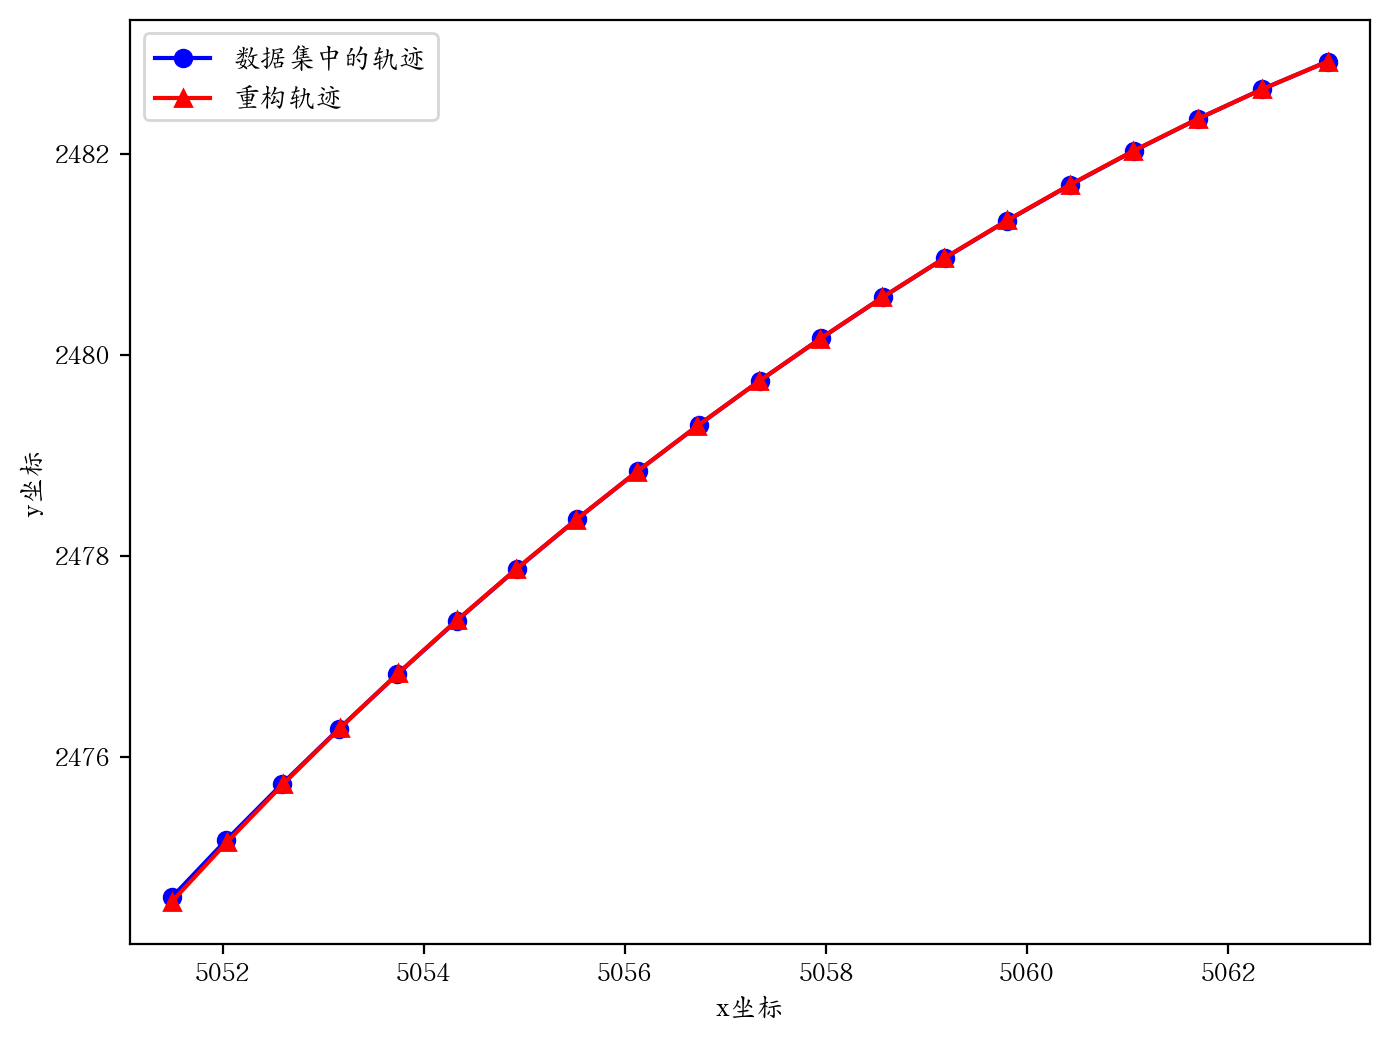

In [7]:
plt.figure(figsize=(8, 6),dpi=200)

plt.rcParams['font.sans-serif'] = ['AR PL UKai CN']  # 指定字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 绘制原始轨迹

# num = 845
num = np.random.randint(0,30000)
print(num)
# num = 29278
plt.plot(val_label.cpu().numpy()[num, :,0], val_label.cpu().numpy()[num, :,1], '-o',c='blue', label='数据集中的轨迹')
plt.plot(val_output.cpu().numpy()[num, :,0], val_output.cpu().numpy()[num, :,1], '-^', c='red', label='重构轨迹')
# plt.title('Reconstructed Trajectory')
plt.xlabel('x坐标')
plt.ylabel('y坐标')
plt.legend()
plt.axis('equal')
plt.show()

# 用原始轨迹直接差分计算
xo = val_label.cpu().numpy()[num, :,0]
yo = val_label.cpu().numpy()[num, :,1]

plt.show()

In [8]:

# 定义专门用来重构轨迹的类, 计算误差ADE

class Reconstruct_Traj(Vehicle_Model_Methods):

    def __init__(self):
        super(Reconstruct_Traj, self).__init__()

    def ADE_err(self,out,label):
        ade = ((out - label) ** 2).sum(dim=2).sqrt().mean()
        return ade
    
    def AMDE_err(self,out,label):
        # 计算每个样本的误差
        error = ((out - label) ** 2).sum(dim=2).sqrt()
        # 提取最大值
        max_error, _ = error.max(dim=1)
        # 对最大值取平均
        amde = max_error.mean()
        return amde
    
    def calculate(self,actions,edagepoint,endstate,mode,labels):

        ax = actions[:,:,0]
        delta = actions[:,:,1]

        if mode == 'init_one':
            out = self.initial_unidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'init_two':
            out = self.initial_bidirectional_reconstruct(ax,delta,edagepoint,endstate)
        elif mode == 'two_point':
            out,condtion = self.two_point_reconstruct(ax, delta, edagepoint, endstate)
        else:
            print(f'没有重构模式{mode}')
            out = torch.zeros(labels.shape, dtype=torch.float32, device=labels.device)
        
        loss_err1 = self.ADE_err(out,labels)
        loss_err1 = loss_err1.cpu().numpy()


        loss_err2 = self.AMDE_err(out,labels)
        loss_err2 = loss_err2.cpu().numpy()

        loss_err = [loss_err1,loss_err2]

        return loss_err

In [9]:
recon_tarj = Reconstruct_Traj()

err_init_one = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_one',val_label)
print('单点单向重构误差',err_init_one)

err_init_two = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'init_two',val_label)
print('单点双向重构误差',err_init_two)

# err_two_point = recon_tarj.calculate(val_action,val_edagepoint,val_endstate,'two_point',val_label)
# print('两点重构误差',err_two_point)



单点单向重构误差 [array(0.0188655, dtype=float32), array(0.050028, dtype=float32)]
单点双向重构误差 [array(0.02139303, dtype=float32), array(0.04396106, dtype=float32)]
